In [32]:
from pynq import Overlay, allocate
from pynq.lib.video import VideoMode
from pynq import MMIO
import cv2
from matplotlib import pyplot as plt
import time
import numpy as np
import math

#overlay = Overlay('rescale/ebaz_hdmi_test.bit')
#overlay = Overlay('rgb2hsv/ebaz_hdmi_test.bit')
overlay = Overlay('mask/ebaz_hdmi_test.bit')
help(overlay)

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay mask/ebaz_hdmi_test.bit. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    axi_gpio_0           : pynq.lib.axigpio.AxiGPIO
    axi_intc             : pynq.overlay.DefaultIP
    axi_uartlite_0       : pynq.overlay.DefaultIP
    axi_vdma             : pynq.lib.video.dma.AxiVDMA
    video_scaler_0       : pynq.overlay.DefaultIP
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [33]:
r_width = 320
r_height = 240

# colors in hsv space
low = np.array((50, 50, 50), np.uint8)
high = np.array((100, 255, 255), np.uint8)

l_speed = 5
r_speed = 5

l_k = 5
r_k = 5

In [3]:
address = 0x42C00000

# HARDWARE CONSTANTS
RX_FIFO = 0x00
TX_FIFO = 0x04

# Status Reg
STAT_REG = 0x08
RX_VALID = 0
RX_FULL = 1
TX_EMPTY = 2
TX_FULL = 3
IS_INTR = 4
OVERRUN_ERR = 5
FRAME_ERR = 6
PARITY_ERR = 7

# Ctrl Reg
CTRL_REG = 0x0C
RST_TX = 0
RST_RX = 1
INTR_EN = 4

# Offset Settings
XGPIO_DATA_OFFSET = 0x0
XGPIO_TRI_OFFSET = 0x4

class UartAXI:
    def __init__(self, address):
        # Setup axi core
        self.uart = MMIO(address, 0x10000, debug=False)
        self.address = address

    def setupCtrlReg(self):
        # Reset FIFOs, disable interrupts
        self.uart.write(CTRL_REG, 1 << RST_TX | 1 << RST_RX)
        time.sleep(1)
        self.uart.write(CTRL_REG, 0)
        time.sleep(1)

    def read(self, count, timeout=10):
        # status = currentStatus(uart) bad idea
        buf = ""
        stop_time = time.time() + timeout
        for i in range(count):
            # Wait till RX fifo has valid data, stop waiting if timeoutpasses
            while (not (self.uart.read(STAT_REG) & 1 << RX_VALID)) and (time() < stop_time):
                pass
            if time.time() >= stop_time:
                break
            buf += chr(self.uart.read(RX_FIFO))
        return buf

    def write(self, buf, timeout=10):
        # Write bytes via UART
        stop_time = time.time() + timeout
        wr_count = 0
        for i in buf:
            # Wait while TX FIFO is Full, stop waiting if timeout passes
            while (self.uart.read(STAT_REG) & 1 << TX_FULL) and (time() < stop_time):
                pass
            # Check timeout
            if time.time() > stop_time:
                break
            self.uart.write(TX_FIFO, ord(i))
            wr_count += 1
        return wr_count
    
uart = UartAXI(address)
# Setup AXI UART register
uart.setupCtrlReg()

In [34]:
scaler = overlay.video_scaler_0
scaler_address = 0x43C00000
help(scaler)

Help on DefaultIP in module pynq.overlay object:

class DefaultIP(builtins.object)
 |  DefaultIP(description)
 |  
 |  Driver for an IP without a more specific driver
 |  
 |  This driver wraps an MMIO device and provides a base class
 |  for more specific drivers written later. It also provides
 |  access to GPIO outputs and interrupts inputs via attributes. More specific
 |  drivers should inherit from `DefaultIP` and include a
 |  `bindto` entry containing all of the IP that the driver
 |  should bind to. Subclasses meeting these requirements will
 |  automatically be registered.
 |  
 |  Attributes
 |  ----------
 |  mmio : pynq.MMIO
 |      Underlying MMIO driver for the device
 |  _interrupts : dict
 |      Subset of the PL.interrupt_pins related to this IP
 |  _gpio : dict
 |      Subset of the PL.gpio_dict related to this IP
 |  
 |  Methods defined here:
 |  
 |  __init__(self, description)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  read(se

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:709: UserWarning: Interrupt interrupt not created: Could not find UIO device for interrupt pin for IRQ number 61
  warnings.warn("Interrupt {} not created: {}".format(interrupt, str(e)))


In [35]:
# Registers
CONTROL = 0x00
IN_WIDTH = 0x10
IN_HEIGHT = 0x18
OUT_WIDTH = 0x20
OUT_HEIGHT = 0x28

AUTO_RESTART = 0x7
AP_START = 0x0

scaler = MMIO(scaler_address, 0x10000, debug=False)

scaler.write(IN_WIDTH, 1280)
scaler.write(IN_HEIGHT, 720)

scaler.write(OUT_WIDTH, 640)
scaler.write(OUT_HEIGHT, 480)

scaler.write(CONTROL, 1 << AUTO_RESTART | 1 << AP_START)

In [36]:
frameMode = VideoMode(640, 480, 8, 50)
vdma = overlay.axi_vdma
vdma.readchannel.mode = frameMode
vdma.readchannel.start()

time.sleep(0.1)

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:709: UserWarning: Interrupt mm2s_introut not created: Could not find UIO device for interrupt pin for IRQ number 61
  warnings.warn("Interrupt {} not created: {}".format(interrupt, str(e)))
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:709: UserWarning: Interrupt s2mm_introut not created: Could not find UIO device for interrupt pin for IRQ number 61
  warnings.warn("Interrupt {} not created: {}".format(interrupt, str(e)))


True

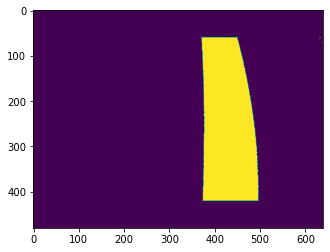

In [39]:
try:
    image = vdma.readchannel.readframe()
except:
    print('Error')

plt.imshow(image)    
cv2.imwrite("hello_hsv.jpg", image) 

In [30]:
vdma.readchannel.stop()

In [5]:
cv2.imwrite("hello.jpg", frame2) 

True

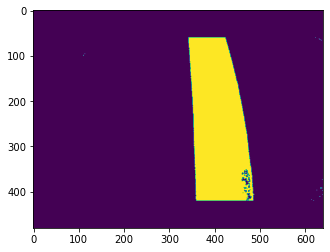

In [45]:
# Get masks by colors in a certain range
mask = cv2.inRange(image, low, high)
plt.imshow(mask) 

In [5]:
uart.write('DD')

2

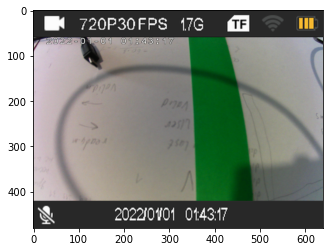

In [46]:
img_rgb = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
plt.imshow(img_rgb) 